# Generate infection network

In [1]:
import pandas as pd
import numpy as np
import matplotlib.colors
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx

## 0. Global variables

Paths:

In [2]:
HUMANS_PATH     = '../outputs/output-humans_time_course.csv'
INFECTIONS_PATH = '../outputs/InfectionNetwork.csv'
EXPORT_GML_PATH = '../outputs/network_static.gml'

Colors:

In [3]:
SUSCEPTIPLE_COLOR = 'silver'
INFECTED_COLOR    = 'red'
RECOVERED_COLOR   = 'limegreen'
DEAD_COLOR        = 'black'

status_colors = {'S': SUSCEPTIPLE_COLOR,
                 'I': INFECTED_COLOR,
                 'R': RECOVERED_COLOR,
                 'D': DEAD_COLOR}

## 1. Read outputs

Humans timecourses:

In [4]:
humans_tc = pd.read_csv(HUMANS_PATH)

Get rid of `Unnamed: 0`:

In [5]:
humans_tc = humans_tc[['h_ID', 'loc', 'status', 'WasInfected', 'Diagnosed', 'Hospitalized', 'ICUed', 'time']]

In [6]:
humans_tc.head()

,h_ID,loc,status,WasInfected,Diagnosed,Hospitalized,ICUed,time
0,187,73,S,0,0,0,0,1
1,1087,389,S,0,0,0,0,1
2,194,75,S,0,0,0,0,1
3,1088,389,S,0,0,0,0,1
4,188,74,S,0,0,0,0,1


In [7]:
humans_tc.shape

(160000, 8)

Infection network:

In [8]:
infections = pd.read_csv(INFECTIONS_PATH)

Get rid of `Unnamed: 0`:

In [9]:
infections = infections[['ID', 'place_of_infection', 'time_of_infection', 'got_infected_by']]

Convert `got_infected_by` to `int`:

Using `pd.Int32Dtype()` in order to keep `NaN`s.

In [10]:
infections['got_infected_by'] = infections['got_infected_by'].astype(pd.Int32Dtype())

In [11]:
infections.head()

,ID,place_of_infection,time_of_infection,got_infected_by
0,187,146,35,940
1,1087,220,17,493
2,194,316,13,502
3,1088,146,17,1256
4,188,29,10,82


In [12]:
infections.shape

(1594, 4)

## 2. Generate static network

Network up to a certain time:

In [13]:
cutoff_time = 4

All infections up to that time except initial (`Nan`) infections:

In [14]:
infections_trimmed = infections[(infections['time_of_infection'] <= cutoff_time) & (infections['got_infected_by'].notna())]

In [15]:
infections_trimmed.head()

,ID,place_of_infection,time_of_infection,got_infected_by
16,195,76,2,196
323,115,44,2,114
559,242,92,1,243
874,872,323,3,873
879,873,323,1,875


In [16]:
humans_tc_with_infected = pd.merge(left = humans_tc,
                                   right = infections, 
                                   how = 'left',
                                   left_on = 'h_ID',
                                   right_on = 'ID').drop(labels = 'ID', axis = 1, inplace = False)

In [17]:
humans_tc_with_infected.head()

,h_ID,loc,status,WasInfected,Diagnosed,Hospitalized,ICUed,time,place_of_infection,time_of_infection,got_infected_by
0,187,73,S,0,0,0,0,1,146.0,35.0,940
1,1087,389,S,0,0,0,0,1,220.0,17.0,493
2,194,75,S,0,0,0,0,1,316.0,13.0,502
3,1088,389,S,0,0,0,0,1,146.0,17.0,1256
4,188,74,S,0,0,0,0,1,29.0,10.0,82


Convert `time_of_infection` and `place_of_infection` to `int`:

Using `pd.Int32Dtype()` in order to keep `NaN`s.

In [18]:
humans_tc_with_infected['time_of_infection'] = humans_tc_with_infected['time_of_infection'].astype(pd.Int32Dtype())
humans_tc_with_infected['place_of_infection'] = humans_tc_with_infected['place_of_infection'].astype(pd.Int32Dtype())

In [19]:
humans_tc_with_infected.shape

(160000, 11)

In [20]:
humans_tc_with_infected.head()

,h_ID,loc,status,WasInfected,Diagnosed,Hospitalized,ICUed,time,place_of_infection,time_of_infection,got_infected_by
0,187,73,S,0,0,0,0,1,146,35,940
1,1087,389,S,0,0,0,0,1,220,17,493
2,194,75,S,0,0,0,0,1,316,13,502
3,1088,389,S,0,0,0,0,1,146,17,1256
4,188,74,S,0,0,0,0,1,29,10,82


Status statistics at cutoff time:

In [21]:
humans_tc_with_infected[humans_tc_with_infected["time"] == cutoff_time].status.value_counts()

S    1559
I      40
R       1
Name: status, dtype: int64

Number of infections at `cutoff_time`, excluding initial infections (`NaN`):

In [22]:
humans_tc_with_infected[(humans_tc_with_infected["time"] == cutoff_time + 1) & (humans_tc_with_infected["time_of_infection"] == cutoff_time)]

,h_ID,loc,status,WasInfected,Diagnosed,Hospitalized,ICUed,time,place_of_infection,time_of_infection,got_infected_by
7583,982,353,I,1,0,0,0,5,353,4,980
7700,651,241,I,1,1,1,0,5,241,4,652
7722,81,30,I,1,0,0,0,5,30,4,80


Generate edge list:

In [23]:
infection_events = list(zip(infections_trimmed['got_infected_by'], infections_trimmed['ID']))

Generate graph:

In [24]:
infection_network_static = nx.DiGraph(infection_events)

Add all nodes so that not just the infected are in the graph:

In [25]:
infection_network_static.add_nodes_from(humans_tc_with_infected['h_ID'])

Draw graph:

In [26]:
edges = infection_network_static.edges()

In [27]:
len(edges)

31

In [28]:
out_degrees = [infection_network_static.out_degree()[edge[0]] for edge in edges]

In [29]:
max(out_degrees)

4

Who is the superspreader:

In [30]:
infections_trimmed.got_infected_by.value_counts(dropna = False)

575    4
390    3
647    3
875    3
80     3
176    2
393    2
983    2
82     1
175    1
114    1
652    1
243    1
650    1
873    1
980    1
196    1
NaN    0
Name: got_infected_by, dtype: Int64

Define a colormap for the edges based on the degrees of the nodes (red = super spreader, green = low spreader):

In [31]:
cdict = {'red':   [(0.0, 0.0, 0.0),  # red increases
                   (1.0, 1.0, 1.0)],

         'green': [(0.0, 1.0, 1.0),  # green decreases
                   (1.0, 0.0, 0.0)],

         'blue':  [(0.0, 0.0, 0.0),  # no blue at all
                   (1.0, 0.0, 0.0)]}

red_green_cm = matplotlib.colors.LinearSegmentedColormap('RedGreen', cdict, max(out_degrees))

Get status of a node (not very safe because it depends on the expression returning only one value):

In [32]:
def get_status(human_ID, time):
    if pd.isnull(human_ID):
        status = 'S'
    elif human_ID not in humans_tc_with_infected.h_ID.values:
        status = 'S'
    else:
        status = humans_tc_with_infected[(humans_tc_with_infected.h_ID == human_ID) & (humans_tc_with_infected.time == time)].status.values[0]

    return status

Test the function:

In [33]:
get_status(214, cutoff_time)

'S'

In [34]:
%%time
node_colors = [status_colors[get_status(node, cutoff_time)] for node in infection_network_static.nodes]

Wall time: 2.98 s


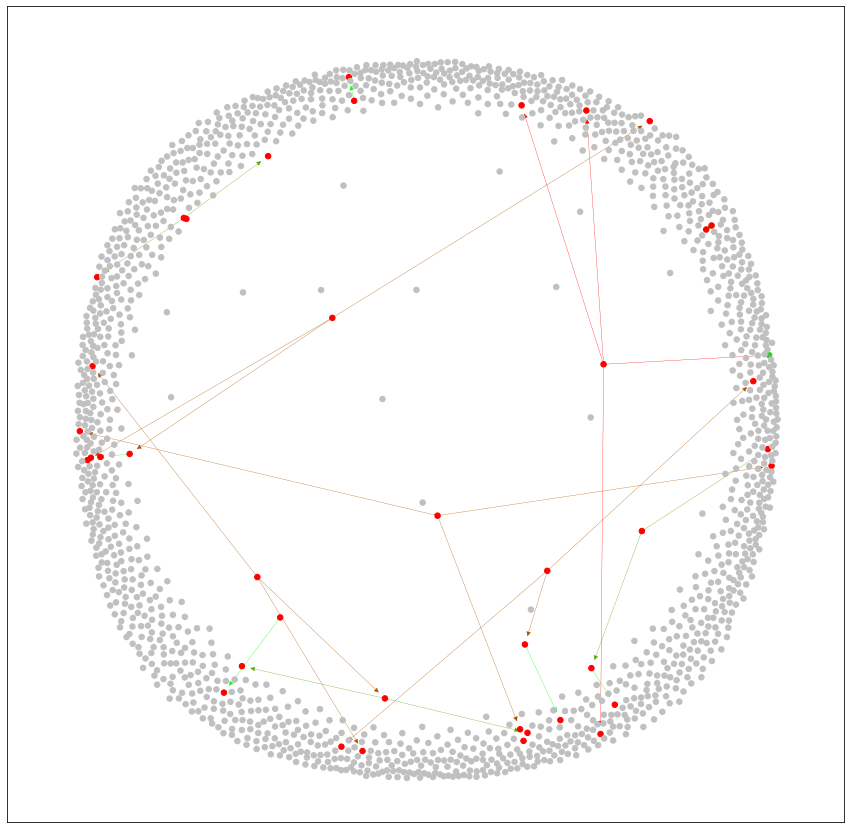

Wall time: 16 s


In [35]:
%%time
plt.figure(figsize = (15, 15))
pos = nx.spring_layout(infection_network_static)
nx.draw_networkx_nodes(infection_network_static, pos, node_color = node_colors, node_size = 30)
nx.draw_networkx_edges(infection_network_static, pos, width = 0.3, edge_color = out_degrees, edge_cmap = red_green_cm, arrows = True)
plt.show()

Save network to `gml` (e.g. for visualization in Cytoscape):

In [36]:
to_string = lambda x: str(x)

nx.write_gml(infection_network_static, path = EXPORT_GML_PATH, stringizer = to_string)